### [Time Series Classification](https://medium.com/the-forecaster/the-complete-introduction-to-time-series-classification-in-python-6af967b16dc9)

Time series classification is a field of supervised machine learning where one or more features are measured across time and used to assign a category.

Therefore, the goal in classifying time series is to assign a label rather than predict the future value of the series.

Time series classification is mostly used with sensor data. It is also a technique used in healthcare, such as analyzing the electrocardiogram (ECG) data.

Furthermore, time series classification is used for speech recognition. Spoken words can be captured as a sound wave over time, and time series classification models can be used to determine what words were spoken, and also identify the speaker.

#### Distance-based models

These models rely on a distance metric to classify samples. The most common metric is the Euclidean distance.

*Dynamic Time Warping (DTW)* is a more robust distance measure, as it finds the optimal match between each point of two series, allowing it to handle series of different lengths and recognize patterns that are slightly out of phase.

- K-nearest neighbors (KNN)
- ShapeDTW

#### Dictionary-based models

These models encode patterns in the series using symbols, and then use the frequency of occurrence of each symbol to classify time series.

- BOSS
- WEASEL
- TDE
- MUSE

#### Ensemble methods

These methods are not models, but rather protocols used with other estimators.

Basically, it involves taking multiple base estimators and combining their prediction to get a final prediction.

The main advantage of ensemble method, is that it can take a univariate model and apply it on a multivariate dataset.

- Bagging
- Weighted ensemble
- Time series forest

#### Feature-based methods

Once again, this group represents methods and not models to extract different features from time series. These features are then used to train any arbitrary machine learning model for classification.

- Summary features (min, max, mean, median, etc.)
- Catch22
- Matrix profile
- TSFresh

#### Interval-based models

These models extract multiple intervals from time series and compute features, using the methods listed above. These features are then used to train a classifier.

- RISE
- CIF
- DrCIF

#### Kernel-based models

With kernel-based models, a kernel function is applied to map the current series to another dimensional space where it would technically be easier to classify.

- Support vector classifier (SVC)
- Rocket
- Arsenal (an ensemble of Rocket)

#### Shapelet classifier

A shapelet classifier relies on extracting shapelets: the most discriminative subsequences of a time series.

The distance between the shapelet and a particular series is then used for classification.

#### Meta classifier

The meta classifier combines different methods listed above to ensemble them and produce a robust classifier that can used with virtually any series and result in good performance.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q numpy pandas matplotlib
!pip install -q scikit-learn sktime numba

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.datasets import load_basic_motions
from sklearn.model_selection import GridSearchCV, KFold

In [4]:
X_train, y_train = load_basic_motions(split='train', return_type='numpy3D')
X_test, y_test = load_basic_motions(split='test', return_type='numpy3D')

In [5]:
print(X_train.shape)

(40, 6, 100)


In [6]:
print(X_test.shape)

(40, 6, 100)


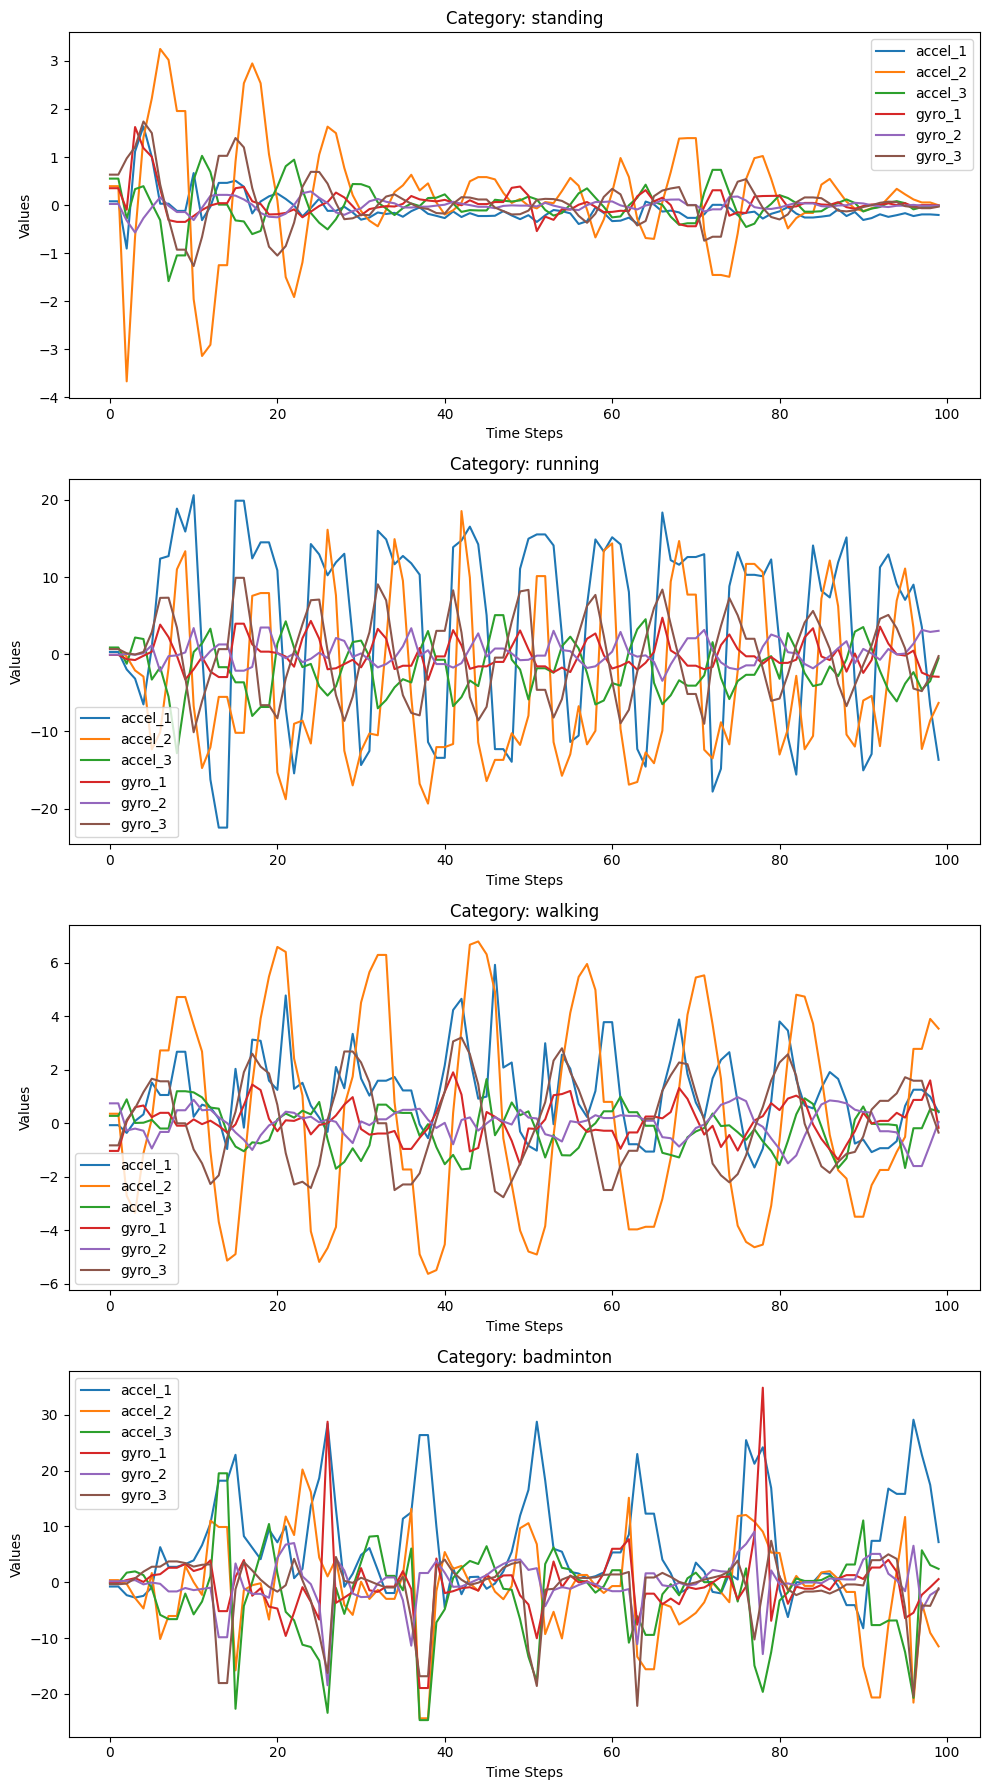

In [7]:
series_indices = [0, 10, 20, 30]
categories = ['standing', 'running', 'walking', 'badminton']
features = ["accel_1", "accel_2", "accel_3", "gyro_1", "gyro_2", "gyro_3"]

selected_series = X_train[series_indices]

fig, axes = plt.subplots(4, 1, figsize=(10, 18))

for i in range(4):  
    for j in range(selected_series.shape[1]):
        axes[i].plot(selected_series[i, j], label=features[j])

    axes[i].set_title(f"Category: {categories[i]}")
    axes[i].set_xlabel("Time Steps")
    axes[i].set_ylabel("Values")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [8]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=1)

params = {
    "distance": ['euclidean', 'dtw']
}
tuned_knn = GridSearchCV(
    knn, 
    params, 
    cv=KFold(n_splits=5)
)
tuned_knn.fit(X_train, y_train)
y_pred_knn = tuned_knn.predict(X_test)

print(tuned_knn.best_params_)

{'distance': 'dtw'}


In [9]:
from sktime.classification.ensemble import BaggingClassifier
from sktime.classification.dictionary_based import WEASEL
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)

base_clf = WEASEL(alphabet_size=3,support_probabilities=True, random_state=42)

clf = BaggingClassifier(
    base_clf, 
    n_estimators=6, # there are 6 features in total 
    n_features=1, 
    random_state=42
)
clf.fit(X_train, y_train)
y_pred_bagging = clf.predict(X_test)
# y_pred_bagging_inv = encoder.inverse_transform(y_pred_bagging)

In [10]:
from sklearn.metrics import classification_report, f1_score

knn_report = classification_report(y_test, y_pred_knn, zero_division=0.0)
print(knn_report)

              precision    recall  f1-score   support

   badminton       1.00      0.90      0.95        10
     running       1.00      1.00      1.00        10
    standing       1.00      1.00      1.00        10
     walking       0.91      1.00      0.95        10

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [11]:
bagging_report = classification_report(y_test, y_pred_bagging)
print(bagging_report)

              precision    recall  f1-score   support

   badminton       0.91      1.00      0.95        10
     running       1.00      0.80      0.89        10
    standing       0.82      0.90      0.86        10
     walking       1.00      1.00      1.00        10

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



In [12]:
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
print(f1_knn)

0.974937343358396


In [13]:
f1_bagging = f1_score(y_test, y_pred_bagging, average='weighted')
print(f1_bagging)

0.9246031746031745


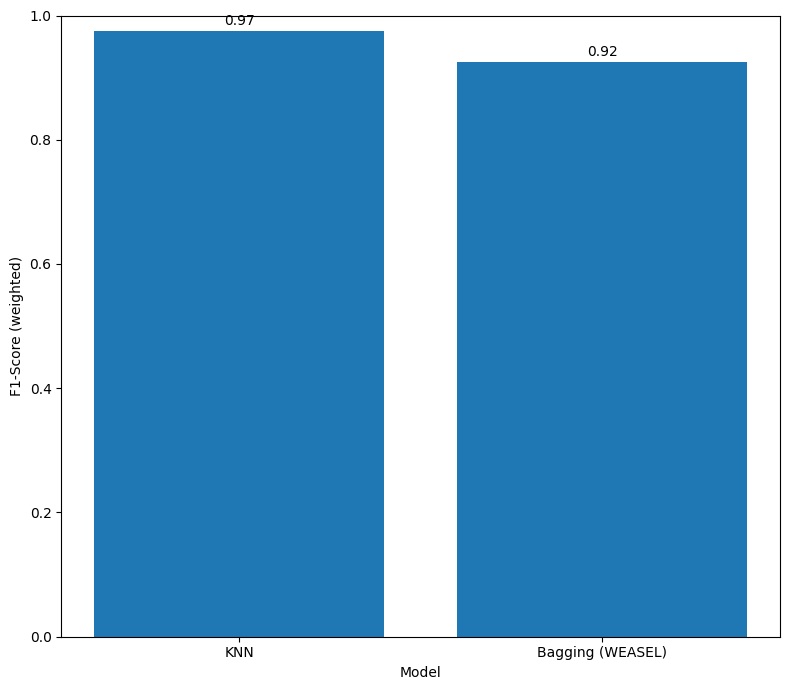

In [14]:
x = ['KNN', 'Bagging (WEASEL)']
y = [f1_knn, f1_bagging]

fig, ax = plt.subplots(figsize=(8,7))
ax.bar(x, y)
ax.set_xlabel('Model')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1)

for i, v in enumerate(y):
    ax.text(x=i, y=v+0.01, s=str(round(v,2)), ha='center')

plt.tight_layout()